In [1]:
%matplotlib notebook
from pyfeti.src.utils import DomainCreator, dict2dfmap, create_selection_operator, DofManager, load_object, save_object
from pyfeti.src.feti_solver import SerialFETIsolver, SolverManager
from pyfeti.src.cyclic import Cyclic_Constraint
from pyfeti.src.linalg import Matrix
from pyfeti.cases.case_generator import FETIcase_builder
from scipy import sparse
import amfe
import numpy as np
import matplotlib.pyplot as plt
import copy


Could not load paradiso!
Could not load paradiso!
Warning! Using python in global path


<IPython.core.display.Javascript object>


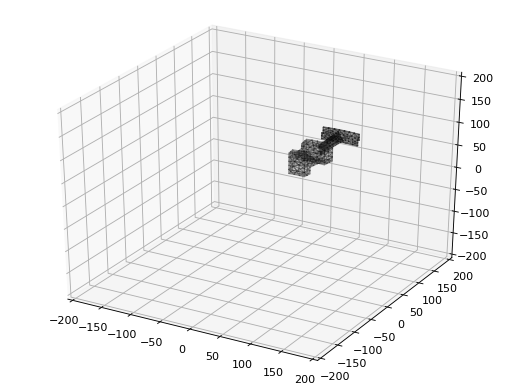

(-200, 200)

In [2]:
#m1 = load_object('3D_simple_bladed_disk_24_sectors_1524_nodes.pkl')
m1 = load_object('meshes/3D_simple_bladed_disk_24_sectors_512_nodes.pkl')

ax1 = amfe.plot3Dmesh(m1,boundaries=False, plot_nodes=False, scale=1000)
bc = np.array([-200,200])
ax1.set_xlim(bc)
ax1.set_ylim(bc)
ax1.set_zlim(bc)

In [3]:
Nsectors = 24
domain_label = 4
cyclic_left_label = 3
cyclic_right_label = 2
dirichlet_label = 1
unit='deg'
tol_radius = 1.0e-5
dimension=3

m1.change_tag_in_eldf('phys_group','RIGHT_ELSET',cyclic_right_label)
m1.change_tag_in_eldf('phys_group','LEFT_ELSET',cyclic_left_label )
m1.change_tag_in_eldf('phys_group','BODY_1_1_SOLID_ELSET',domain_label)
m1.change_tag_in_eldf('phys_group','BODY_1_1_ELSET',5)
m1.change_tag_in_eldf('phys_group','DIRICHLET_ELSET',dirichlet_label)


# creating material
my_material = amfe.KirchhoffMaterial(E=210.0E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)

my_system1 = amfe.MechanicalSystem()
my_system1.set_mesh_obj(m1)
my_system1.set_domain(4,my_material)

K1, _ = my_system1.assembly_class.assemble_k_and_f()
M1 = my_system1.assembly_class.assemble_m()

el_df = copy.deepcopy(m1.el_df)
try:
    connectivity = []
    for _,item in el_df.iloc[:, m1.node_idx:].iterrows():
        connectivity.append(list(item.dropna().astype(dtype='int64')))
    el_df['connectivity'] = connectivity
except:
    pass
    


sector_angle = 360/Nsectors 
id_matrix = my_system1.assembly_class.id_matrix
id_map_df = dict2dfmap(id_matrix)
nodes_coord = m1.nodes

cyc_obj = Cyclic_Constraint(id_map_df,
                            el_df,
                            nodes_coord,
                            dirichlet_label,
                            cyclic_left_label,
                            cyclic_right_label,
                            sector_angle,
                            unit=unit,
                            tol_radius = tol_radius,
                            dimension=dimension)

translate_dict = {}
translate_dict['d'] = dirichlet_label
translate_dict['r'] = cyclic_right_label
translate_dict['l'] = cyclic_left_label

s = cyc_obj.s
B_local_dict = {}
for key, value in translate_dict.items():
    B_local_dict[value] = s.build_B(key)


mesh_list = [m1.rot_z(i*360/Nsectors) for i in range(Nsectors)]
#plot_mesh_list(mesh_list)

system_list = []
K_dict = {}
M_dict = {}
B_dict = {}
f_dict = {}
for i,mi in enumerate(mesh_list):
    sysi = amfe.MechanicalSystem()
    sysi.set_mesh_obj(mi)
    sysi.set_domain(domain_label,my_material)
    system_list.append(sysi)
    K1, _ = sysi.assembly_class.assemble_k_and_f()
    M1 = sysi.assembly_class.assemble_m()
    K_dict[i+1] = Matrix(K1,key_dict=s.selection_dict).eliminate_by_identity('d')
    M_dict[i+1] = Matrix(M1,key_dict=s.selection_dict).eliminate_by_identity('d',multiplier=0.0)
    plus = +1
    minus = -1
    local_index = i+1
    if i+2>Nsectors:
        plus = -23

    if i-1<0:
        minus = +23

    sign_plus = np.sign(plus)
    sign_minus = np.sign(plus)

    B_dict[local_index] = {(local_index,local_index+plus): sign_plus*B_local_dict[cyclic_left_label],
                            (local_index,local_index+minus): sign_minus*B_local_dict[cyclic_right_label]}

    f_dict[local_index] = np.zeros(K1.shape[0])

feti_obj1 = SerialFETIsolver(K_dict,B_dict,f_dict,tolerance=1.0e-12,pseudoinverse_kargs={'method':'splusps','tolerance':1.0E-8})
feti_obj2 = SerialFETIsolver(M_dict,B_dict,f_dict,tolerance=1.0e-12,pseudoinverse_kargs={'method':'splusps','tolerance':1.0E-8})
manager = feti_obj1.manager 
managerM = feti_obj2.manager
manager.build_local_to_global_mapping()



/home/ge72tih/miniconda3/lib/python3.7/site-packages/pandas-0.24.2-py3.7-linux-x86_64.egg/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Preallocating the stiffness matrix
Done preallocating stiffness matrix with 1431 elements and 1536 dofs.
Time taken for preallocation: 0.03 seconds.
xyz direction choosen for cyclic symmetry
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2862 elements and 1536 dofs.
Time taken for preallocation: 0.06 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2862 elements and 1536 dofs.
Time taken for preallocation: 0.05 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2862 elements and 1536 dofs.
Time taken for preallocation: 0.05 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2862 elements and 1536 dofs.
Time taken for preallocation: 0.07 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness matrix with 2862 elements and 1536 dofs.
Time taken for preallocation: 0.06 seconds.
Preallocating the stiffness matrix
Done preallocating stiffness 

In [4]:
if False:
    import os
    case_folder = 'case_512'
    save_object(feti_obj1,os.path.join(case_folder,'feti_obj1.pkl'))
    save_object(feti_obj2,os.path.join(case_folder,'feti_obj2.pkl'))
    save_object(manager,os.path.join(case_folder,'manager.pkl'))
    save_object(managerM,os.path.join(case_folder,'managerM.pkl'))

In [5]:
nmodes =30
def update_system(system_list,V):
    v_dict = manager.vector2localdict(V,manager.global2local_primal_dofs)
    for i,sysi in enumerate(system_list):
        vi = v_dict[i+1]
        sysi.u_output = list(vi.T)
    return system_list

def plot_system_list(system_list,mode_id,factor):
    fig1 = plt.figure(figsize=(10,10))
    ax2 = fig1.add_subplot(1,1,1, projection='3d')
    bc = np.array([-200,200])
    ax2.set_xlim(bc)
    ax2.set_ylim(bc)
    ax2.set_zlim(bc)

    for i,sysi in enumerate(system_list):
        amfe.plot_3D_displacement(sysi,displacement_id=(nmodes - mode_id),ax=ax2,factor=factor,plot_nodes=False,scale=1000,alpha=1.0,linewidth=0.05)
        
    #plt.legend('off')

In [6]:
#load results


Vprimal = load_object('case_512/Vprimal.pkl')
eigval_ = load_object('case_512/eigval_.pkl')
val_p = np.sort(1/eigval_)
val_p

freq_p = np.sqrt(val_p)/(2.0*np.pi)
freq_p

array([ 642.95051944, 1145.00672181, 1149.68873382, 1153.90691374,
       1158.1732086 , 1211.52185429, 1345.60519388, 1347.34887332,
       1859.29545114, 1859.79091621, 2681.03354911, 2743.40109346,
       2886.5787598 , 2919.16408297, 3194.8470413 , 3246.48847102,
       3289.41429209, 3444.38380621, 3485.88448296, 3699.45345581,
       3742.43013573, 4084.05048014, 4196.91749077, 4489.22206671,
       4535.37968402, 4539.15642302, 4649.01507647, 4661.79683418,
       4834.14852324, 4851.57353116])

In [7]:
Vprimal.shape

(36864, 30)

In [8]:
system_list = update_system(system_list,Vprimal)

<IPython.core.display.Javascript object>


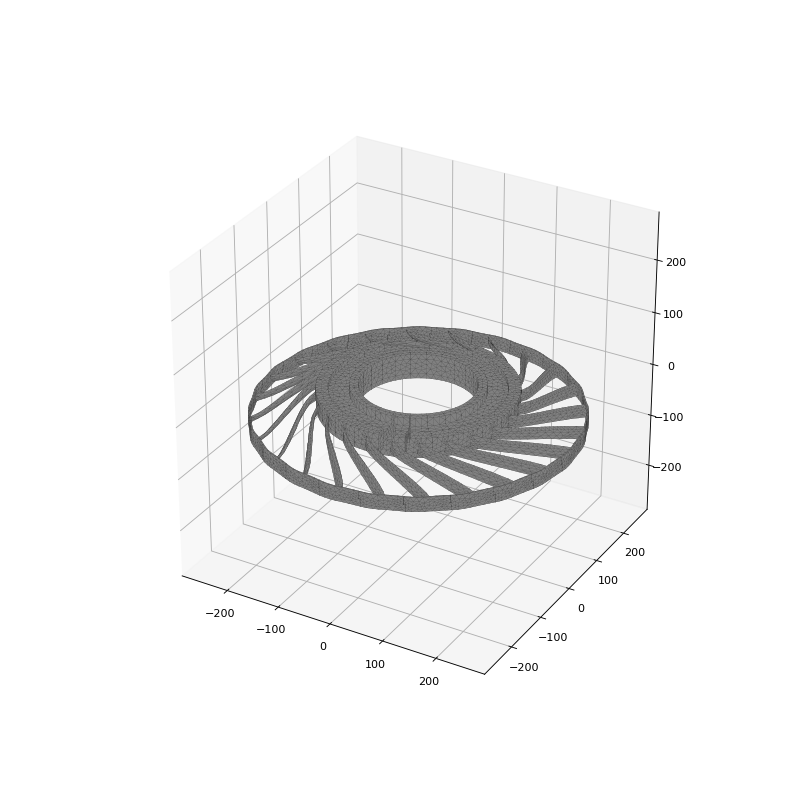

In [9]:
plot_system_list(system_list,mode_id=1,factor=10)

In [10]:
#load results


V_wp_ = load_object('case_512/V_wp_.pkl')
eigval_without_projection_= load_object('case_512/eigval_without_projection_.pkl')
val_wp = np.sort(1.0/eigval_without_projection_.real)
val_wp

freq_wp = np.sqrt(val_wp)/(2.0*np.pi)
freq_wp

array([ 596.92919741,  610.55164485,  620.20684734,  671.42376166,
        678.79399157,  769.61486197,  779.49189062,  911.28320354,
        916.30921104,  945.17886612, 1006.38869438, 1050.72045901,
       1052.16476336, 1052.16476336, 1057.10273748, 1057.47827722,
       1057.47827722, 1063.76930139, 1067.16392368, 1068.51381312,
       1068.97606197, 1072.43221838, 1072.43221838, 1077.58173292,
       1081.23904023, 1093.86191972, 1101.81302272, 1115.00449045,
       1115.00449045, 1123.31424415])

In [11]:
system_list = update_system(system_list,V_wp_.real)

<IPython.core.display.Javascript object>


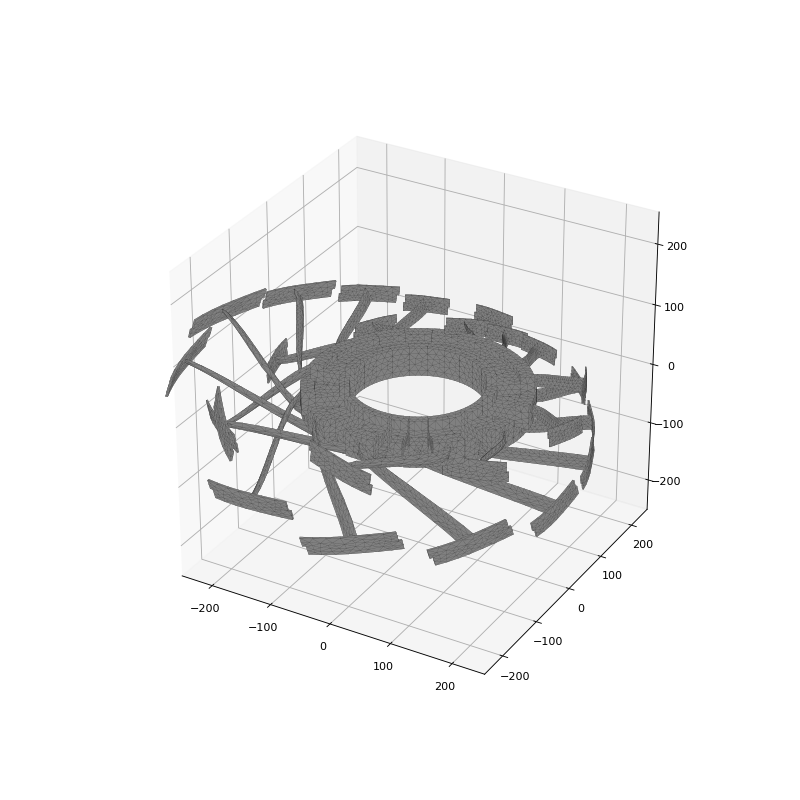

In [12]:
plot_system_list(system_list,mode_id=1,factor=10)

In [13]:
#load results


V = load_object('case_512/V.pkl')
eigval = load_object('case_512/eigval.pkl')
val = np.sort(1.0/eigval.real)
val

freq = np.sqrt(val)/(2.0*np.pi)
freq

array([ 599.36096421,  615.81860372,  618.28730195,  664.82897986,
        680.63674099,  774.09606597,  788.23533883,  935.89584404,
        935.89584404, 1013.39842359, 1030.11993669, 1044.75836943,
       1045.43863427, 1045.43863427, 1064.99073439, 1067.80737988,
       1069.08213811, 1069.08213811, 1072.83199902, 1074.11564792,
       1077.82129145, 1077.82129145, 1093.22765161, 1099.97498374,
       1109.41192223, 1109.41192223, 1129.53790066, 1140.17733117,
       1156.02143123, 1163.439721  ])

In [14]:
system_list = update_system(system_list,V.real)

<IPython.core.display.Javascript object>


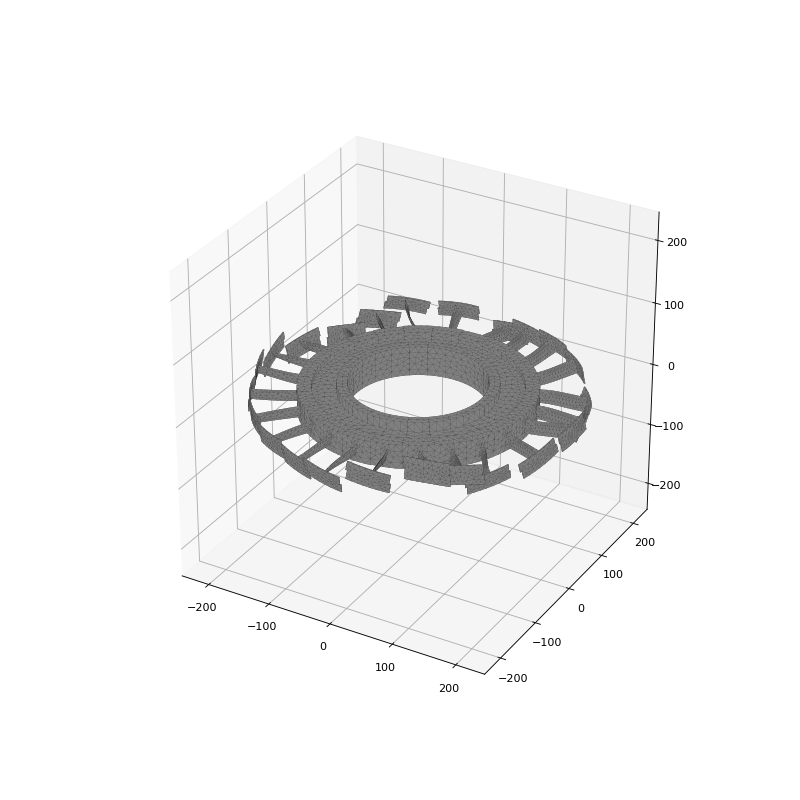

In [16]:
plot_system_list(system_list,mode_id=1,factor=1)